# kNN & Clustering

__Суммарное количество баллов: 10 + 3 bonus__

## kNN, рак и спам

В этом части домашнего задания Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
from IPython.display import display

### Задание 1 (1 балл)

#### 1. (0.5 балла)
Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`.

In [2]:
CANCER_DATA_PATH = 'hw2_data/cancer.csv'
SPAM_DATA_PATH = 'hw2_data/spam.csv'

In [3]:
def read_cancer_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    X, y = read_spam_dataset(path_to_csv)
    y = y.apply(lambda x: 1 if x == 'M' else 0)
    return X, y
    
def read_spam_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    X = df.drop(columns=['label'])
    y = df['label']
    return X, y

In [4]:
X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
X_spam, y_spam = read_spam_dataset(SPAM_DATA_PATH)

#### 2. (0.5 балла) 

Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

In [5]:
def train_test_split(X, y, ratio):
    # Возвращает X_train, y_train, X_test, y_test
    # X_train и X_test - массив векторов - две части массива X, разделенного в состветсви с коэффициентом ratio
    # y_train и y_test - соответствующие X_train и X_test метки классов
    
    X = pd.DataFrame(X)
    X['label'] = y
    
    train_set = X.sample(frac=0.9)
    test_set = X.drop(train_set.index)

    train_set.reset_index(inplace=True) 
    train_set.drop(columns=['index'], inplace=True)
    test_set.reset_index(inplace=True)
    test_set.drop(columns=['index'], inplace=True)
    
    X_train = train_set.drop(columns=['label'])
    y_train = train_set['label']
    
    X_test = test_set.drop(columns=['label'])
    y_test = test_set['label']
        
    return X_train, y_train, X_test, y_test

### Задание 2 (1.5 балла)

Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса. 

__Precision__ отражает то, насколько редко мы ошибаемся, когда говорим, что объект пренадлежит к классу. 

__Recall__ же отражает то, насколько редко классификатор неправильно классифицирует объекты данного класса.

__Accuracy__ отражает то, какую часть выборки классификатор отнес к правильному классу.

In [6]:
def get_precision_recall_accuracy(y_pred, y_true):
    # Возвращает precision, recall и accuracy
    # precision - набор значений метрики precision для каждого класса
    # recall - набор значений метрики recall для каждого класса
    # accuracy - число, отражающее общую точность предсказания
    
    precision = []
    recall = []
    accuracy = []
    
    classes = (0, 1)
    for x in classes:
        tp = np.sum((y_pred == x) & (y_true == x))
        fp = np.sum((y_pred == x) & (y_true != x))
        tn = np.sum((y_pred != x) & (y_true != x))
        fn = np.sum((y_pred != x) & (y_true == x))
        
        assert tp + fp > 0
        assert tp + fn > 0
        
        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))
        accuracy.append((tp + tn) / (tp + fp + tn + fn))
    
    return precision, recall, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [7]:
def plot_precision_recall(X_train, y_train, X_test, y_test, min_k=1, max_k=30):
    ks = list(range(min_k, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
        
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [8]:
def plot_roc_curve(X_train, y_train, X_test, y_test, min_k=1, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(min_k, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    i = min_k
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, label=f'k = {i}')
        i += 1
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend()
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 3  (3 балла)


## 1. (2 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево. (При желании можно воспользоваться библиотечной реализацией дерева)

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток "обучать" классификатор. 

Метод `predict_proba` должен предсказывать вероятности классов для заданного набора данных основываясь на классах соседей

#### KDTree implementation

In [9]:
# based on (i.e. almost complete ripoff):
# https://scipy-cookbook.readthedocs.io/items/KDTree_example.html

from copy import copy

def build_tree(data, leafsize=30):

    ndim = data.shape[1]
    ndata = data.shape[0]

    # hrect - гиперпрямоугольник, охватывающий все объекты
    # hrect содержит массивы с мин. и макс. значением тех координат, по которым уже разбили
    hrect = np.zeros((2, ndim))
    hrect[0, :] = data.min(axis=0) 
    hrect[1, :] = data.max(axis=0)

    idx = np.argsort(data[:, 0], kind='mergesort')  # indexes of rows sorted by 1st coordinat
    data[:, :] = data[idx, :]  # rearrage rows according to 1st coordinat
    med = data[ndata // 2, 0]

    left_hrect = hrect.copy()
    right_hrect = hrect.copy()

    # rectangles are splitted by median of 1st coordinate
    right_hrect[0, 0] = med
    left_hrect[1, 0] = med

    tree = [(None, None, left_hrect, right_hrect, None, None)]

    stack = [
        (data[:ndata // 2, :], idx[:ndata // 2], 1, 0, True),
        (data[ndata //2:, :], idx[ndata // 2:], 1, 0, False)
    ]

    while stack:
        data, didx, depth, parent, leftbranch = stack.pop()
        ndata = data.shape[0]   # number of rows left in this subtree
        cur_node = len(tree)

        # update parent
        pidx, pdata, pleft_hrect, pright_hrect, left, right = tree[parent]
        if leftbranch:
            l, r = cur_node, right
        else:
            l, r = left, cur_node
        tree[parent] = (pidx, pdata, pleft_hrect, pright_hrect, l, r)
        
        if ndata <= leafsize:  # leaf node
            _idx = didx.copy()
            _data = data.copy()
            leaf = (_idx, _data, None, None, 0, 0)
            tree.append(leaf)

        else:
            splitdim = depth % ndim
            idx = np.argsort(data[:, splitdim], kind='mergesort')
            data[:, :] = data[idx, :]
            didx = didx[idx]   # sequentially sorted by several columns

            stack.append((data[:ndata//2, :], didx[:ndata//2], depth + 1, cur_node, True))
            stack.append((data[ndata//2:, :], didx[ndata//2:], depth + 1, cur_node, False))
            if leftbranch:
                left_hrect = pleft_hrect.copy()
                right_hrect = pleft_hrect.copy()
            else:
                left_hrect = pright_hrect.copy()
                right_hrect = pright_hrect.copy()

            med = data[ndata//2, splitdim]
            left_hrect[1, splitdim] = med
            right_hrect[0, splitdim] = med

            tree.append((None, None, left_hrect, right_hrect, None, None))
            
    return tree

def intersect(hrect, r2, centroid):
    """ checks whether hrect and hypersphere (centroid, r2) intersect """
    maxval = hrect[1, :]
    minval = hrect[0, :]
    p = centroid.copy()
    # print(type(p))
    idx = p < minval
    p[idx] = minval[idx]
    idx = p > maxval
    p[idx] = maxval[idx]
    
    return np.sum((p - centroid)**2) < r2

def quadratic_search(datapoint, lidx, ldata, K):
    nrow, ncol = ldata.shape
    K = K if K < nrow else nrow
    
    distances = np.sum((ldata - datapoint)**2, axis=1)

    idx = np.argsort(distances, kind='mergesort')
    idx = idx[:K]
    return list(zip(distances[idx], lidx[idx]))
    
def search_kdtree(tree, datapoint, K):
    """find K nearest neighbouts of datapoint"""
    stack = [tree[0]]
    knn = [(np.inf, None)] * K
    
    _datapt = datapoint
    # print(_datapt)
    
    while stack:
        leaf_idx, leaf_data, left_hrect, right_hrect, left, right = stack.pop()
        
        if leaf_idx is not None:  # leaf ?
            _knn = quadratic_search(_datapt, leaf_idx, leaf_data, K)
            
            if _knn[0][0] < knn[-1][0]:
                knn = sorted(knn + _knn)[:K]
        else:
            # check distance if from farthest nearest neighbour is greater than distance to 
            # other hrectangles
            if intersect(left_hrect, knn[-1][0], _datapt):  
                stack.append(tree[left])
            if intersect(right_hrect, knn[-1][0], _datapt):
                stack.append(tree[right])
    
    return knn

#### KDTree test

In [10]:
# test - each object should be closest to itself
# upd. also scaling shoudn't break it...
from sklearn.preprocessing import StandardScaler

data = X_cancer.copy()
tree = build_tree(np.array(data))

scaler = StandardScaler()
scaler.fit(data)
data_scaled = data.copy()
data_scaled[data_scaled.columns] = scaler.transform(data)

tree_scaled = build_tree(np.array(data_scaled))

for i in range(data.shape[0]):
    x = np.array(data.iloc[i, :])
    res1 = search_kdtree(tree, x, 1)
    
    x_scaled = np.array(data_scaled.iloc[i, :])
    res2 = search_kdtree(tree_scaled, x_scaled, 1)
    
    assert res1[0][1] == res2[0][1] == i, (res1[0][1], res2[0][1], i)

In [11]:
from sklearn.preprocessing import StandardScaler

data = X_spam.copy()
tree = build_tree(np.array(data))

scaler = StandardScaler()
scaler.fit(data)
data_scaled = data.copy()
data_scaled[data_scaled.columns] = scaler.transform(data)

tree_scaled = build_tree(np.array(data_scaled))

for i in range(data.shape[0]):
    x = np.array(data.iloc[i, :])
    res1 = search_kdtree(tree, x, 1)
    
    x_scaled = np.array(data_scaled.iloc[i, :])
    res2 = search_kdtree(tree_scaled, x_scaled, 1)
    
    assert res1[0][1] == res2[0][1] == i, (res1[0][1], res2[0][1], i)
    # assert res1[0][1] == res2[0][1] == i

AssertionError: (24, 24, 26)

In [12]:
# hmmmmm...
np.all(data.iloc[24, :] == data.iloc[26, :])

True

In [13]:
# all in all seems to work
search_kdtree(tree_scaled, x_scaled, 3)

[(0.0, 24), (0.0, 26), (0.02198280508044161, 1533)]

wonder if we should drop the duplicates...

---
---

In [14]:
class KNearest:
    def __init__(self, n_neighbors=5, leaf_size=30):
        self.K = n_neighbors
        self.leaf_size = leaf_size 
        self.kdtree = None
        self.y_true = None
    
    def fit(self, X, y):
        self.kdtree = build_tree(np.array(X))
        self.y_true = y
        
    def predict_proba(self, X):
        # Возвращает матрицу, в которой строки соответствуют элементам X, а столбцы - классам. На пересечении строки и столбца должна быть указана вероятность того, что элемент относится к классу
        # Вероятность рассчитывается как количество ближайших соседей с данным классом деленное на общее количество соседей
        if isinstance(X, pd.DataFrame):
            
            res = np.zeros(shape=X.shape)
            
            for i, row in X.iterrows():

                knn_index = [res[1] for res in search_kdtree(self.kdtree, np.array(row), self.K)]
                knn = self.y_true.reindex(knn_index)

                k0 = np.sum(knn == 0)
                k1 = np.sum(knn == 1)

                res[i][0] = k0 / self.K
                res[i][1] = k1 / self.K 
                
            return res  
        else:
            raise NotImplementedError('This one only accepts DataFrames...')     
                       
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
        
        # можно бы ещё порог подкрутить
        prob = self.predict_proba(X)
        res = np.zeros(len(prob))
        res[prob[:, 1] > 0.3] = 1
        return res


Наконец, протестируем наш классификатор на различных наборах данных

In [15]:
# let's scale beforehead
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_cancer)
X_cancer_scaled = X_cancer.copy()
X_cancer_scaled[X_cancer_scaled.columns] = scaler.transform(X_cancer)

scaler.fit(X_spam)
X_spam_scaled = X_spam.copy()
X_spam_scaled[X_spam_scaled.columns] = scaler.transform(X_spam)

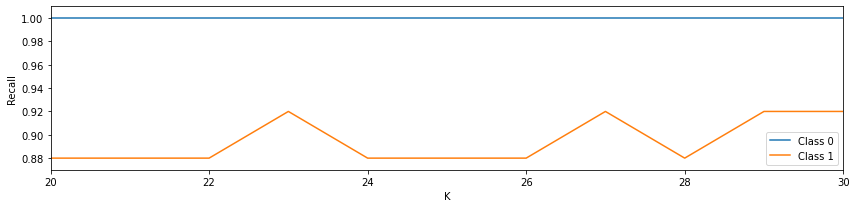

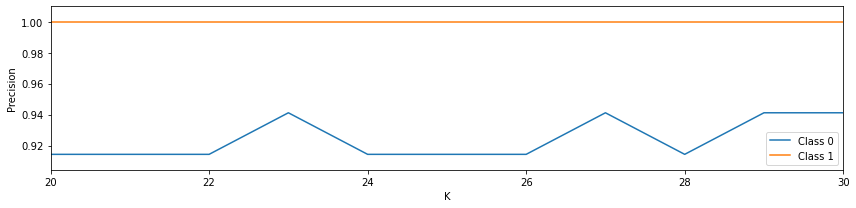

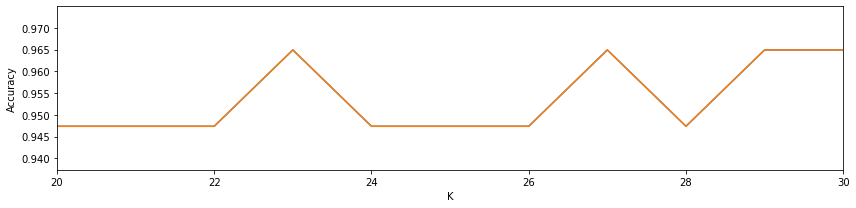

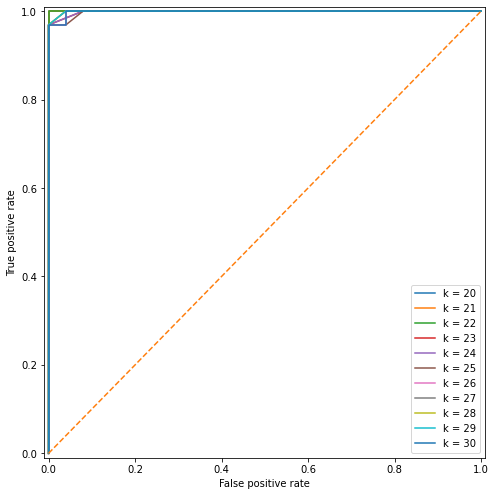

In [16]:
np.random.seed(0)
min_k = 20
max_k = 30
X_train, y_train, X_test, y_test = train_test_split(X_cancer_scaled, y_cancer, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, min_k=min_k, max_k=max_k)
plot_roc_curve(X_train, y_train, X_test, y_test, min_k=min_k, max_k=max_k)

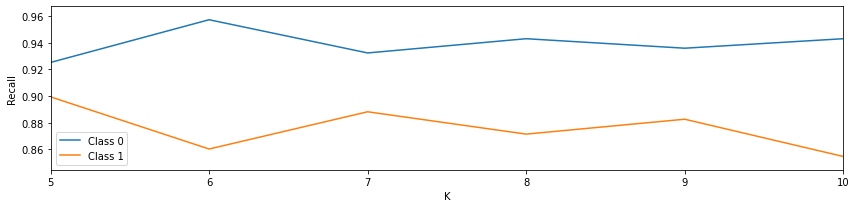

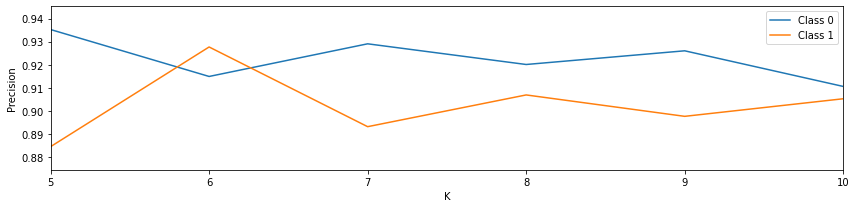

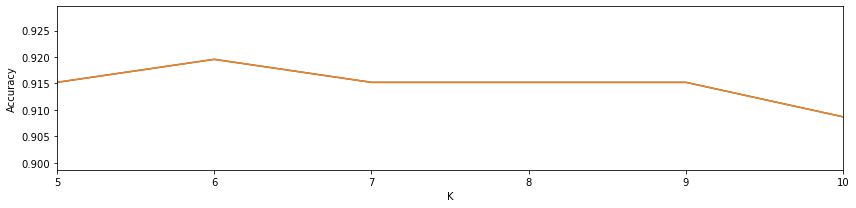

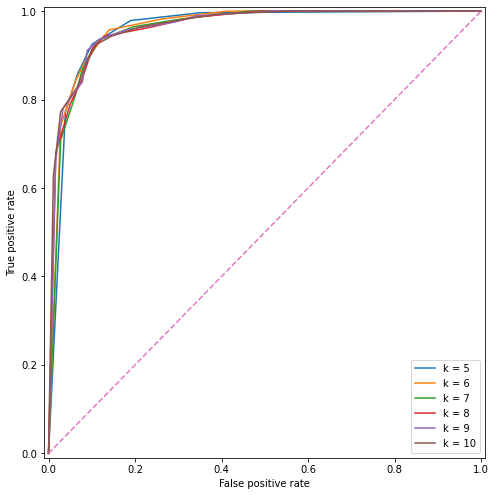

In [17]:
np.random.seed(0)
min_k = 5
max_k = 10
X_train, y_train, X_test, y_test = train_test_split(X_spam_scaled, y_spam, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, min_k=min_k, max_k=max_k)
plot_roc_curve(X_train, y_train, X_test, y_test, min_k=min_k, max_k=max_k)

#### 2. (1.5 балла)

Проанализируйте полученные графики. Какой параметр `k` кажется лучшим для каждой из задач? Какая из метрик лучше всего отражает качество модели? 

_Ваш ответ_

1. В задаче с раком ошибка 2-го рода, false negative - сказать, что всё хорошо, при наличии рака - опасней, чем лишний раз отправить пациента на проверку в случае false positive, т.ч. Recall можно придать больший вес (понизив порог, с которого модель относит объекты к классу 1). Оптимальное значение (по ROC-кривой) k = 22. 
2. В задаче с почтой ошибка 1-го рода (отправка потенциально важного письма в спам) более нежелательна, т.ч. адекватней использовать Precision. На глаз по ROC-кривой модели примерно одинаковы, но пусть будет k = 6. 

## Clustering

В этой части домашнего задания предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [18]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import copy
import cv2
from collections import deque

In [19]:
def visualize_clasters(X, labels, centroids=None, figsize=(9, 9), unique_colors=None, iteration_number=None):
    if unique_colors is None:
        unique_labels = np.unique(labels)
        unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=figsize)
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    if centroids is not None:
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red')
    if iteration_number:
        plt.title(f'Iteration #{iteration_number}')
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

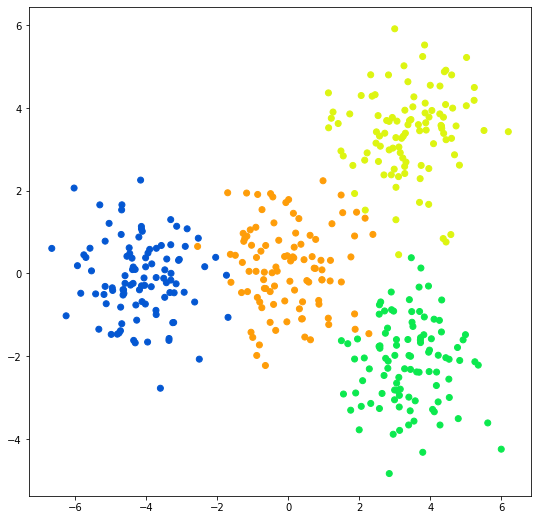

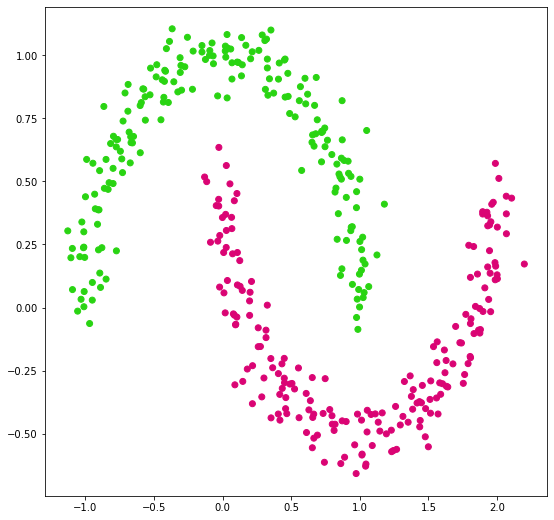

In [20]:
np.random.seed(0)
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 4 (1.5 балла)

Первый метод, который предлагается реализовать - метод K средних.

__Описание методов__

`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

__Инициализация кластеров__

Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [21]:
class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=300):
        self.init = init
        self.n_clusters = n_clusters
        self.mi = max_iter
        
    def fit(self, X, y=None, epsilon=1e-10, plot_trajectory=False):
        unique_colors = np.random.random((self.n_clusters, 3))
        
        self.init_clusters(X, plot=plot_trajectory)
        
        labels = np.zeros(X.shape[0], dtype=np.int64)
        for i, row in enumerate(X):
            labels[i] = np.argmin(np.sum((self.centroids - row)**2, axis=1))
            assert labels[i] < 4, labels[i]
        
        for iteration in range(self.mi):
            # updating centroids
            new_centroids = self.centroids.copy()
            for i in range(self.n_clusters):
                cluster_size = X[labels == i].shape[0]
                if cluster_size > 0:
                    coordinate_sum = X[labels == i].sum(axis=0) 
                    new_centroids[i] = coordinate_sum / cluster_size
            
            # check for convergence
            if np.sum((new_centroids - self.centroids)**2) < epsilon:
                print(f'Converged in {iteration} iterations')
                break
            else:
                self.centroids = new_centroids
                
            # update labels
            for i, row in enumerate(X):
                labels[i] = np.argmin(np.sum((self.centroids - row)**2, axis=1))
                assert labels[i] < 4, labels[i]
                
            # plot current state
            if plot_trajectory:
                visualize_clasters(X, labels, self.centroids, figsize=(4,4), 
                                   unique_colors=unique_colors, iteration_number=iteration+1)
        else:
            print('Iteration limit reached')
        
    
    def init_clusters(self, X, plot):
        n_samples, n_features = X.shape
        self.centroids = np.zeros(shape=(self.n_clusters, n_features))
    
        if self.init == 'random':
            lower = X.min(axis=0)
            upper = X.max(axis=1)
            for i in range(n_features):
                self.centroids[:, i] = np.random.uniform(lower[i], upper[i], size=self.n_clusters)
                
        elif self.init == 'sample':
            tmp = set()
            while len(tmp) < self.n_clusters:
                tmp.add(np.random.randint(n_samples))
            tmp = list(tmp)
#             print(list(tmp))
#             print(*tmp)
            for i in range(self.n_clusters):
                self.centroids[i] = X[tmp[i]]
                
            pass
        else:  # k-means++
            self.centroids[0] = X[np.random.randint(n_samples)]
            min_dist = np.full(n_samples, np.inf)
            for i in range(1, self.n_clusters):
                # calculate distances to already selected centroids
                min_dist = np.full(n_samples, np.inf)
                for j in range(i): 
                    ctr = self.centroids[j]
                    dist = np.sum((X - self.centroids[j])**2, axis=1)
                    min_dist[min_dist > dist] = dist[min_dist > dist]
                self.centroids[i] = X[np.random.choice(n_samples, p=min_dist/min_dist.sum())]
        
        # plot initial condition
        if plot:
            ax = sns.scatterplot(x=X[:, 0], y=X[:, 1], color='blue')
            sns.scatterplot(x=self.centroids[:, 0], y=self.centroids[:, 1], color='red', ax=ax)
            ax.set_title(f'Initial condition ({self.init})')
    
    def predict(self, X):
        labels = np.zeros(X.shape[0], np.int64)
        for i, row in enumerate(X):
            labels[i] = np.argmin(np.sum((self.centroids - row)**2, axis=1))
        return labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

### 1) blobs, init='random'

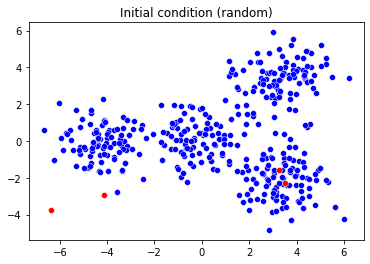

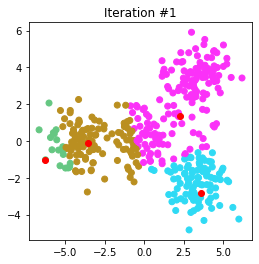

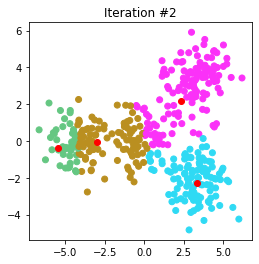

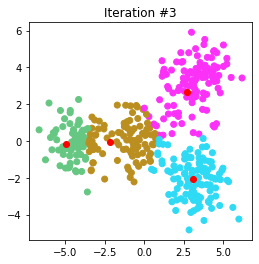

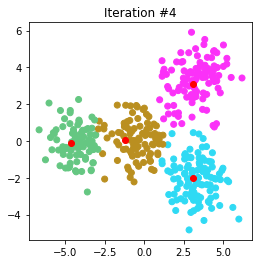

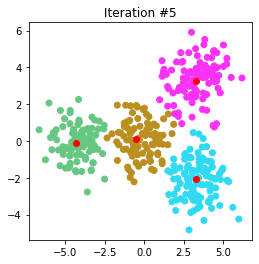

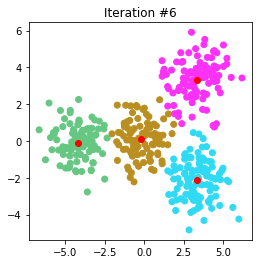

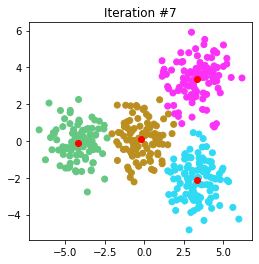

Converged in 7 iterations
Visualize clusters:


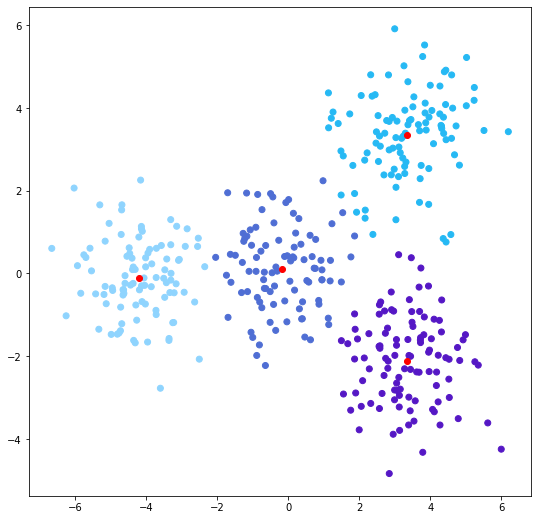

In [22]:
np.random.seed(28)

kmeans = KMeans(n_clusters=4, init='random')
kmeans.fit(X_1, epsilon=1e-5, plot_trajectory=True)
labels = kmeans.predict(X_1)
print('Visualize clusters:')
visualize_clasters(X_1, labels, kmeans.centroids)

### 2) blobs, init='knn++'

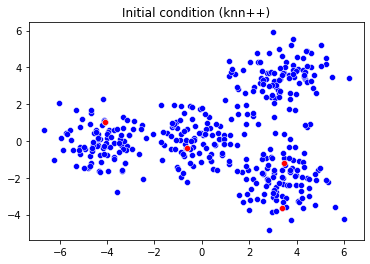

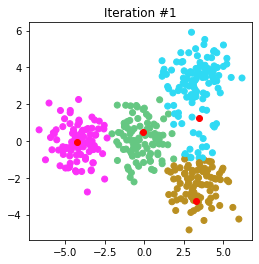

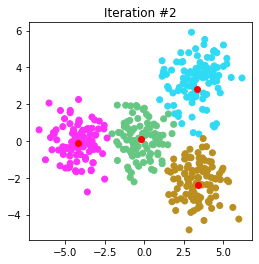

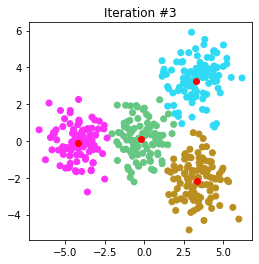

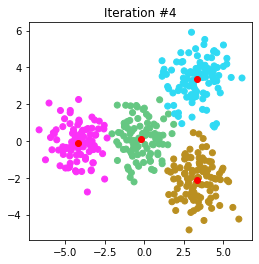

Converged in 4 iterations
Visualize clusters:


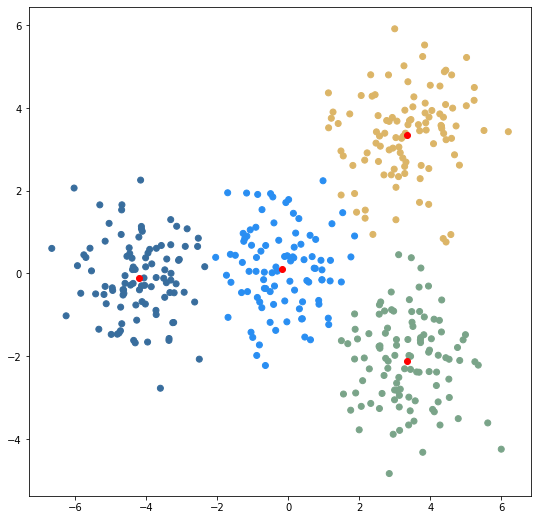

In [23]:
np.random.seed(28)

kmeans = KMeans(n_clusters=4, init='knn++')
kmeans.fit(X_1, epsilon=1e-5, plot_trajectory=True)
labels = kmeans.predict(X_1)
print('Visualize clusters:')
visualize_clasters(X_1, labels, kmeans.centroids)

### 3) Moons, init='sample'

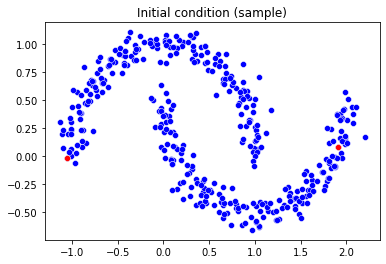

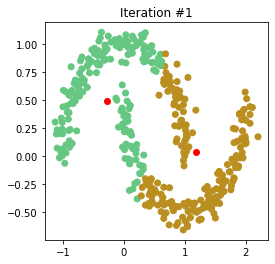

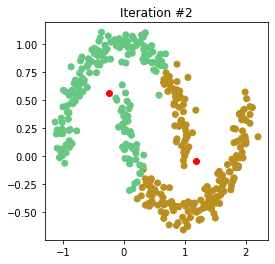

Converged in 2 iterations


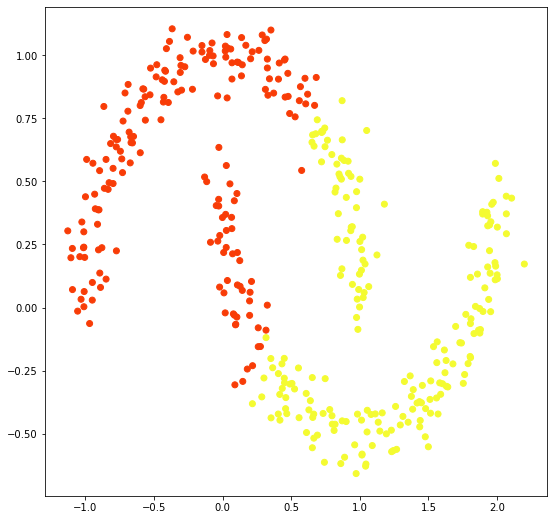

In [24]:
np.random.seed(28)
kmeans = KMeans(n_clusters=2, init='sample')
kmeans.fit(X_2, epsilon=1e-3, plot_trajectory=True)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### 4) Moons, init='knn++'

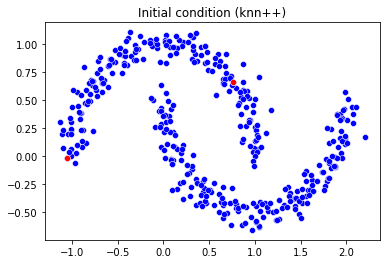

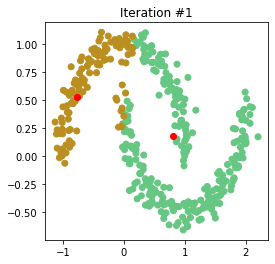

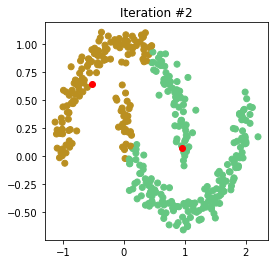

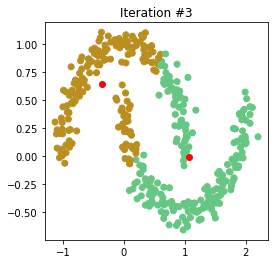

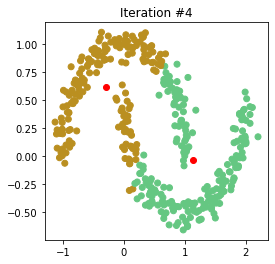

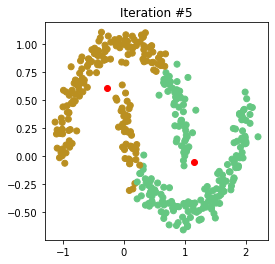

Converged in 5 iterations


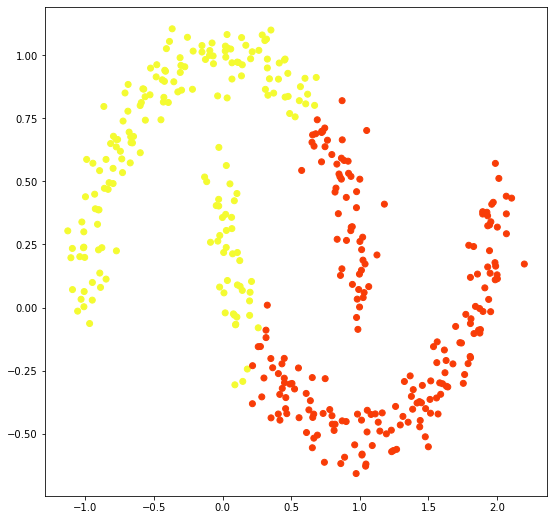

In [25]:
np.random.seed(28)
kmeans = KMeans(n_clusters=2, init='knn++')
kmeans.fit(X_2, epsilon=1e-3, plot_trajectory=True)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 5 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Возможные метрики__

* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [26]:
from sklearn.neighbors import KDTree


class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        
        self.kdtree = None
        
    def fit_predict(self, X, y=None):
        self.kdtree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        n_samples, n_features = X.shape
        
        visited = np.zeros(n_samples)
        labels = np.zeros(n_samples, dtype=np.int64)
        

        def dfs(i, current_cluster):
            visited[i] = 1
            neighbors = self.kdtree.query_radius(X[i].reshape(1, -1), self.eps)[0]
            if len(neighbors) >= self.min_samples:
                labels[i] = current_cluster
                labels[neighbors] = current_cluster
                for n in neighbors:
                    if not visited[n]:
                        dfs(n, current_cluster)
                
        current_cluster = 0
        for i in range(n_samples):
            if not np.all(visited):
                if not visited[i]:
                    current_cluster += 1
                    dfs(i, current_cluster)
            else:
                break
                
        unique_labels = np.sort(np.unique(labels))
        for i, ul in enumerate(unique_labels):
            labels[labels == ul] = i

        return labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

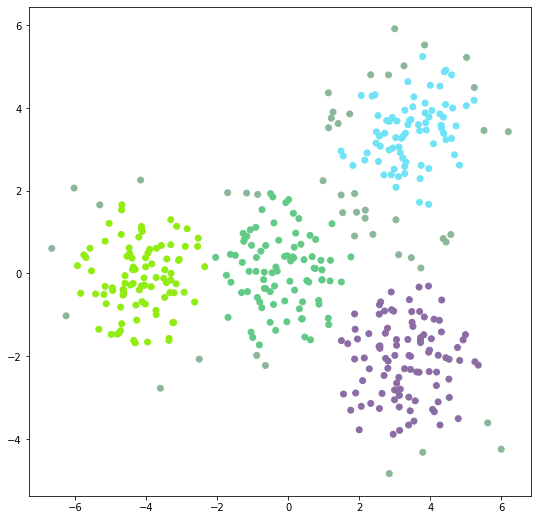

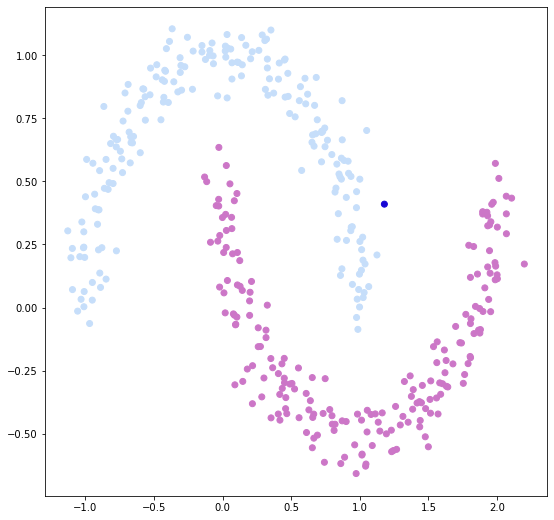

In [27]:
np.random.seed(0)
dbscan = DBScan(min_samples=10, eps=0.75)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(min_samples=3, eps=0.20)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 6 (0.5 балла)

Проанализируйте полученные результаты. 

Какой метод лучше справился с кластеризацией каждого из датасетов? Почему? 

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для определения качества кластеризации. 

Какие значения метрики свидетельствуют о хорошей кластеризации - большие или маленькие?

_Ваш ответ_

In [28]:
?silhouette_score

Object `silhouette_score` not found.


In [29]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

### 1) blobs

_Davies-Bouildin score_ - меньше = лучше, т.к. он отражает меру "похожести" между соседними кластерами (отношение расстояний внутри кластера к расстояниям между кластерами).

_Silhouette score_ - больше = лучше, т.к. там в числителе стоит разность между расстоянием до ближайшего объекта из соседнего кластера и средним расстоянием между объектами в кластере, метрика эта выше тем, чем более кластеры в среднем удалены друг от друга.

In [30]:
np.random.seed(0)

kmeans = KMeans(n_clusters=4, init='knn++')
kmeans.fit(X_1, epsilon=1e-5, plot_trajectory=False)
labels_knn = kmeans.predict(X_1)

dbscan = DBScan(min_samples=10, eps=0.75)
labels_db = dbscan.fit_predict(X_1)

# чтобы не считать неопознанные объекты за один кластер... 
X_1_db_score = X_1[labels_db != 0]
labels_db_score = labels_db[labels_db != 0]

print('=' * 10)
print('Davies-Bouildin score')
print(f'KNN++: {davies_bouldin_score(X_1, labels_knn)}')
print(f'DBScan: {davies_bouldin_score(X_1, labels_db)}')
print(f'DBScan (labeled only): {davies_bouldin_score(X_1_db_score, labels_db_score)}')
print('')
print('Silhouette score ')
print(f'KNN++: {silhouette_score(X_1, labels_knn)}')
print(f'DBScan: {silhouette_score(X_1, labels_db)}')
print(f'DBScan (labeled only): {silhouette_score(X_1_db_score, labels_db_score)}')

Converged in 8 iterations
Davies-Bouildin score
KNN++: 0.5741447919591743
DBScan: 1.6044022315340882
DBScan (labeled only): 0.5209821794562031

Silhouette score 
KNN++: 0.5686804402456915
DBScan: 0.48040852943642975
DBScan (labeled only): 0.6183765937421015


В задаче, где заранее известно число кластеров, а сами кластеры образуют (гипер)сферы, KNN показывает себя лучше - для DBscan непросто подобрать параметры, и объекты, лежащие на периферии кластеров, часто остаются непомеченными.

### 2) moons

In [31]:
np.random.seed(0)

kmeans = KMeans(n_clusters=2, init='knn++')
kmeans.fit(X_2, epsilon=1e-5, plot_trajectory=False)
labels_knn = kmeans.predict(X_2)

dbscan = DBScan(min_samples=3, eps=0.20)
labels_db = dbscan.fit_predict(X_2)

# чтобы не считать неопознанные объекты за один кластер... 
X_2_db_score = X_2[labels_db != 0]
labels_db_score = labels_db[labels_db != 0]

print('=' * 10)
print('Davies-Bouildin score')
print(f'KNN++: {davies_bouldin_score(X_2, labels_knn)}')
print(f'DBScan: {davies_bouldin_score(X_2, labels_db)}')
print(f'DBScan (labeled only): {davies_bouldin_score(X_2_db_score, labels_db_score)}')
print('')
print('Silhouette score ')
print(f'KNN++: {silhouette_score(X_2, labels_knn)}')
print(f'DBScan: {silhouette_score(X_2, labels_db)}')
print(f'DBScan (labeled only): {silhouette_score(X_2_db_score, labels_db_score)}')

Converged in 7 iterations
Davies-Bouildin score
KNN++: 0.7729225988160818
DBScan: 1.2476806529304023
DBScan (labeled only): 1.1670343006702655

Silhouette score 
KNN++: 0.489345465582252
DBScan: 0.03099723661683854
DBScan (labeled only): 0.3255115861322541


Поскольку метрики основаны на среднем расстоянии между объектами, а кластеры в этой задаче имеют особую форму (и она нам известна), и определяются расстоянием конкретно между соседними объектами, то метрики эти не слишком информативны.

Здесь DBScan показывает себя лучше, т.к. он способен "поймать" сложную форму кластеров.

### Bonus. (3 балла)

#### 1. (2.5 балла)

Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Linkage-функции__

__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [32]:
class AgglomertiveClustering:
    def __init__(self, n_clusters=16, linkage="average"):
        raise NotImplementedError()
    
    def fit_predict(self, X, y=None):
        raise NotImplementedError()

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

In [33]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2)
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

NotImplementedError: 

#### 2. (0.5 балла)

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для `AgglomertiveClustering` с `K-means` и `DBSCAN`. 

Какой из методов лучше произвел кластеризацию данных?

_Ваш ответ_

In [ ]:
# YOUR_CODE